##**Notebook PC#09 - Part 2**
## Autoencoder training and manifold visualization for the MNIST database.
## Code produced by previous students of IA353. Thank you for making PC#09 (Part 2) still more complete and informative.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Ariel Góes de Castro <br>
**Aluno(a):** Francisco Germano Vogt

### Loading the main libraries

In [1]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2024-05-28 15:34:56.672820: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 15:34:56.736307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 15:34:56.736357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 15:34:56.737588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 15:34:56.746662: I tensorflow/core/platform/cpu_feature_guar

### Reading the data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.
X = x_train.reshape((x_train.shape[0], -1))

### Convolutional Autoencoder

The dense layers of Part 1 were replaced by convolutional layers, which promotes a reduction in the total number of adjustable weights.

In [4]:
encoder = tf.keras.models.Sequential([
    Conv2D(8, (3, 3), activation='selu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(256, (3, 3), activation='selu', padding='same'),
    Flatten(),
    Dense(2),

], name='encoder')

# Define the decoder
decoder = tf.keras.models.Sequential([
    Dense(256, activation='relu'),
    Reshape((1, 1, 256)),
    Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='selu'),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='selu'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='selu'),
    Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='selu'),
    Conv2D(8, (3, 3), padding='same', activation='selu'),
    Conv2D(1, (3, 3), padding='same', activation=None),
], name='decoder')

autoencoder = Sequential([encoder, decoder])
autoencoder.summary(expand_nested=True)

2024-05-28 15:34:59.499666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 15:34:59.537634: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 15:34:59.537858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 2)                 393922    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)            (None, 28, 28, 8)         80       |
|                                                               |
| max_pooling2d (MaxPooling  (None, 14, 14, 8)         0        |
| 2D)                                                           |
|                                                               |
| conv2d_1 (Conv2D)          (None, 14, 14, 16)        1168     |
|                                                               |
| max_pooling2d_1 (MaxPooli  (None, 7, 7, 16)          0        |
| ng2D)                                                         |
|                                                               |
| conv2d_2 (Conv2D)          (None, 7, 7, 32)          4

In [5]:
autoencoder.compile(optimizer = "adam", loss = "mse")

history = autoencoder.fit(x_train.reshape((-1, 28, 28, 1)), x_train.reshape((-1, 28, 28, 1)), batch_size = 128, epochs = 20, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-05-28 15:35:02.555384: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-28 15:35:02.722992: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-28 15:35:02.937981: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-28 15:35:04.918974: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f84acf38ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 15:35:04.919013: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-28 15:35:04.925594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716921305.040114   11253 device_compiler.

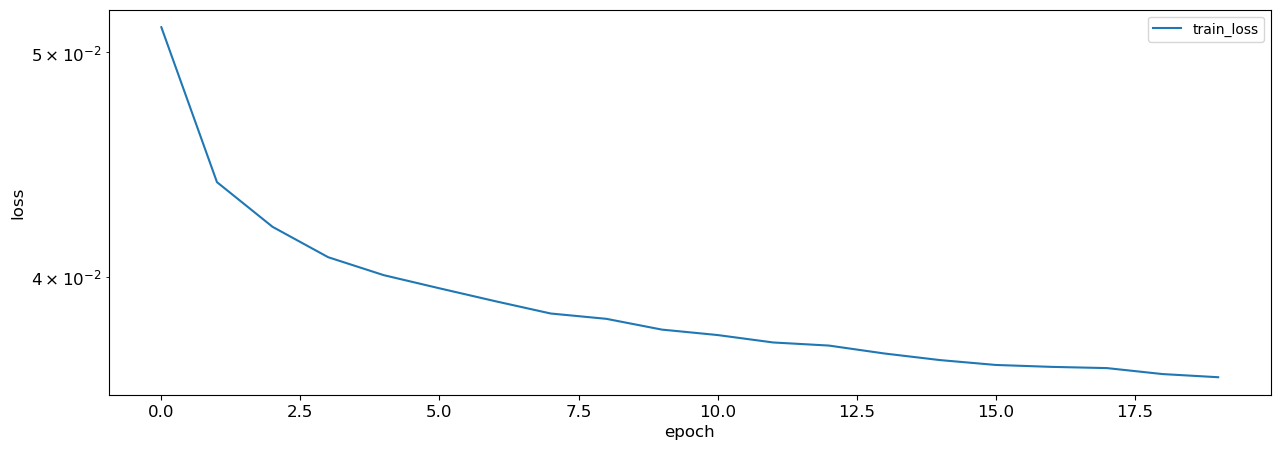

In [6]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

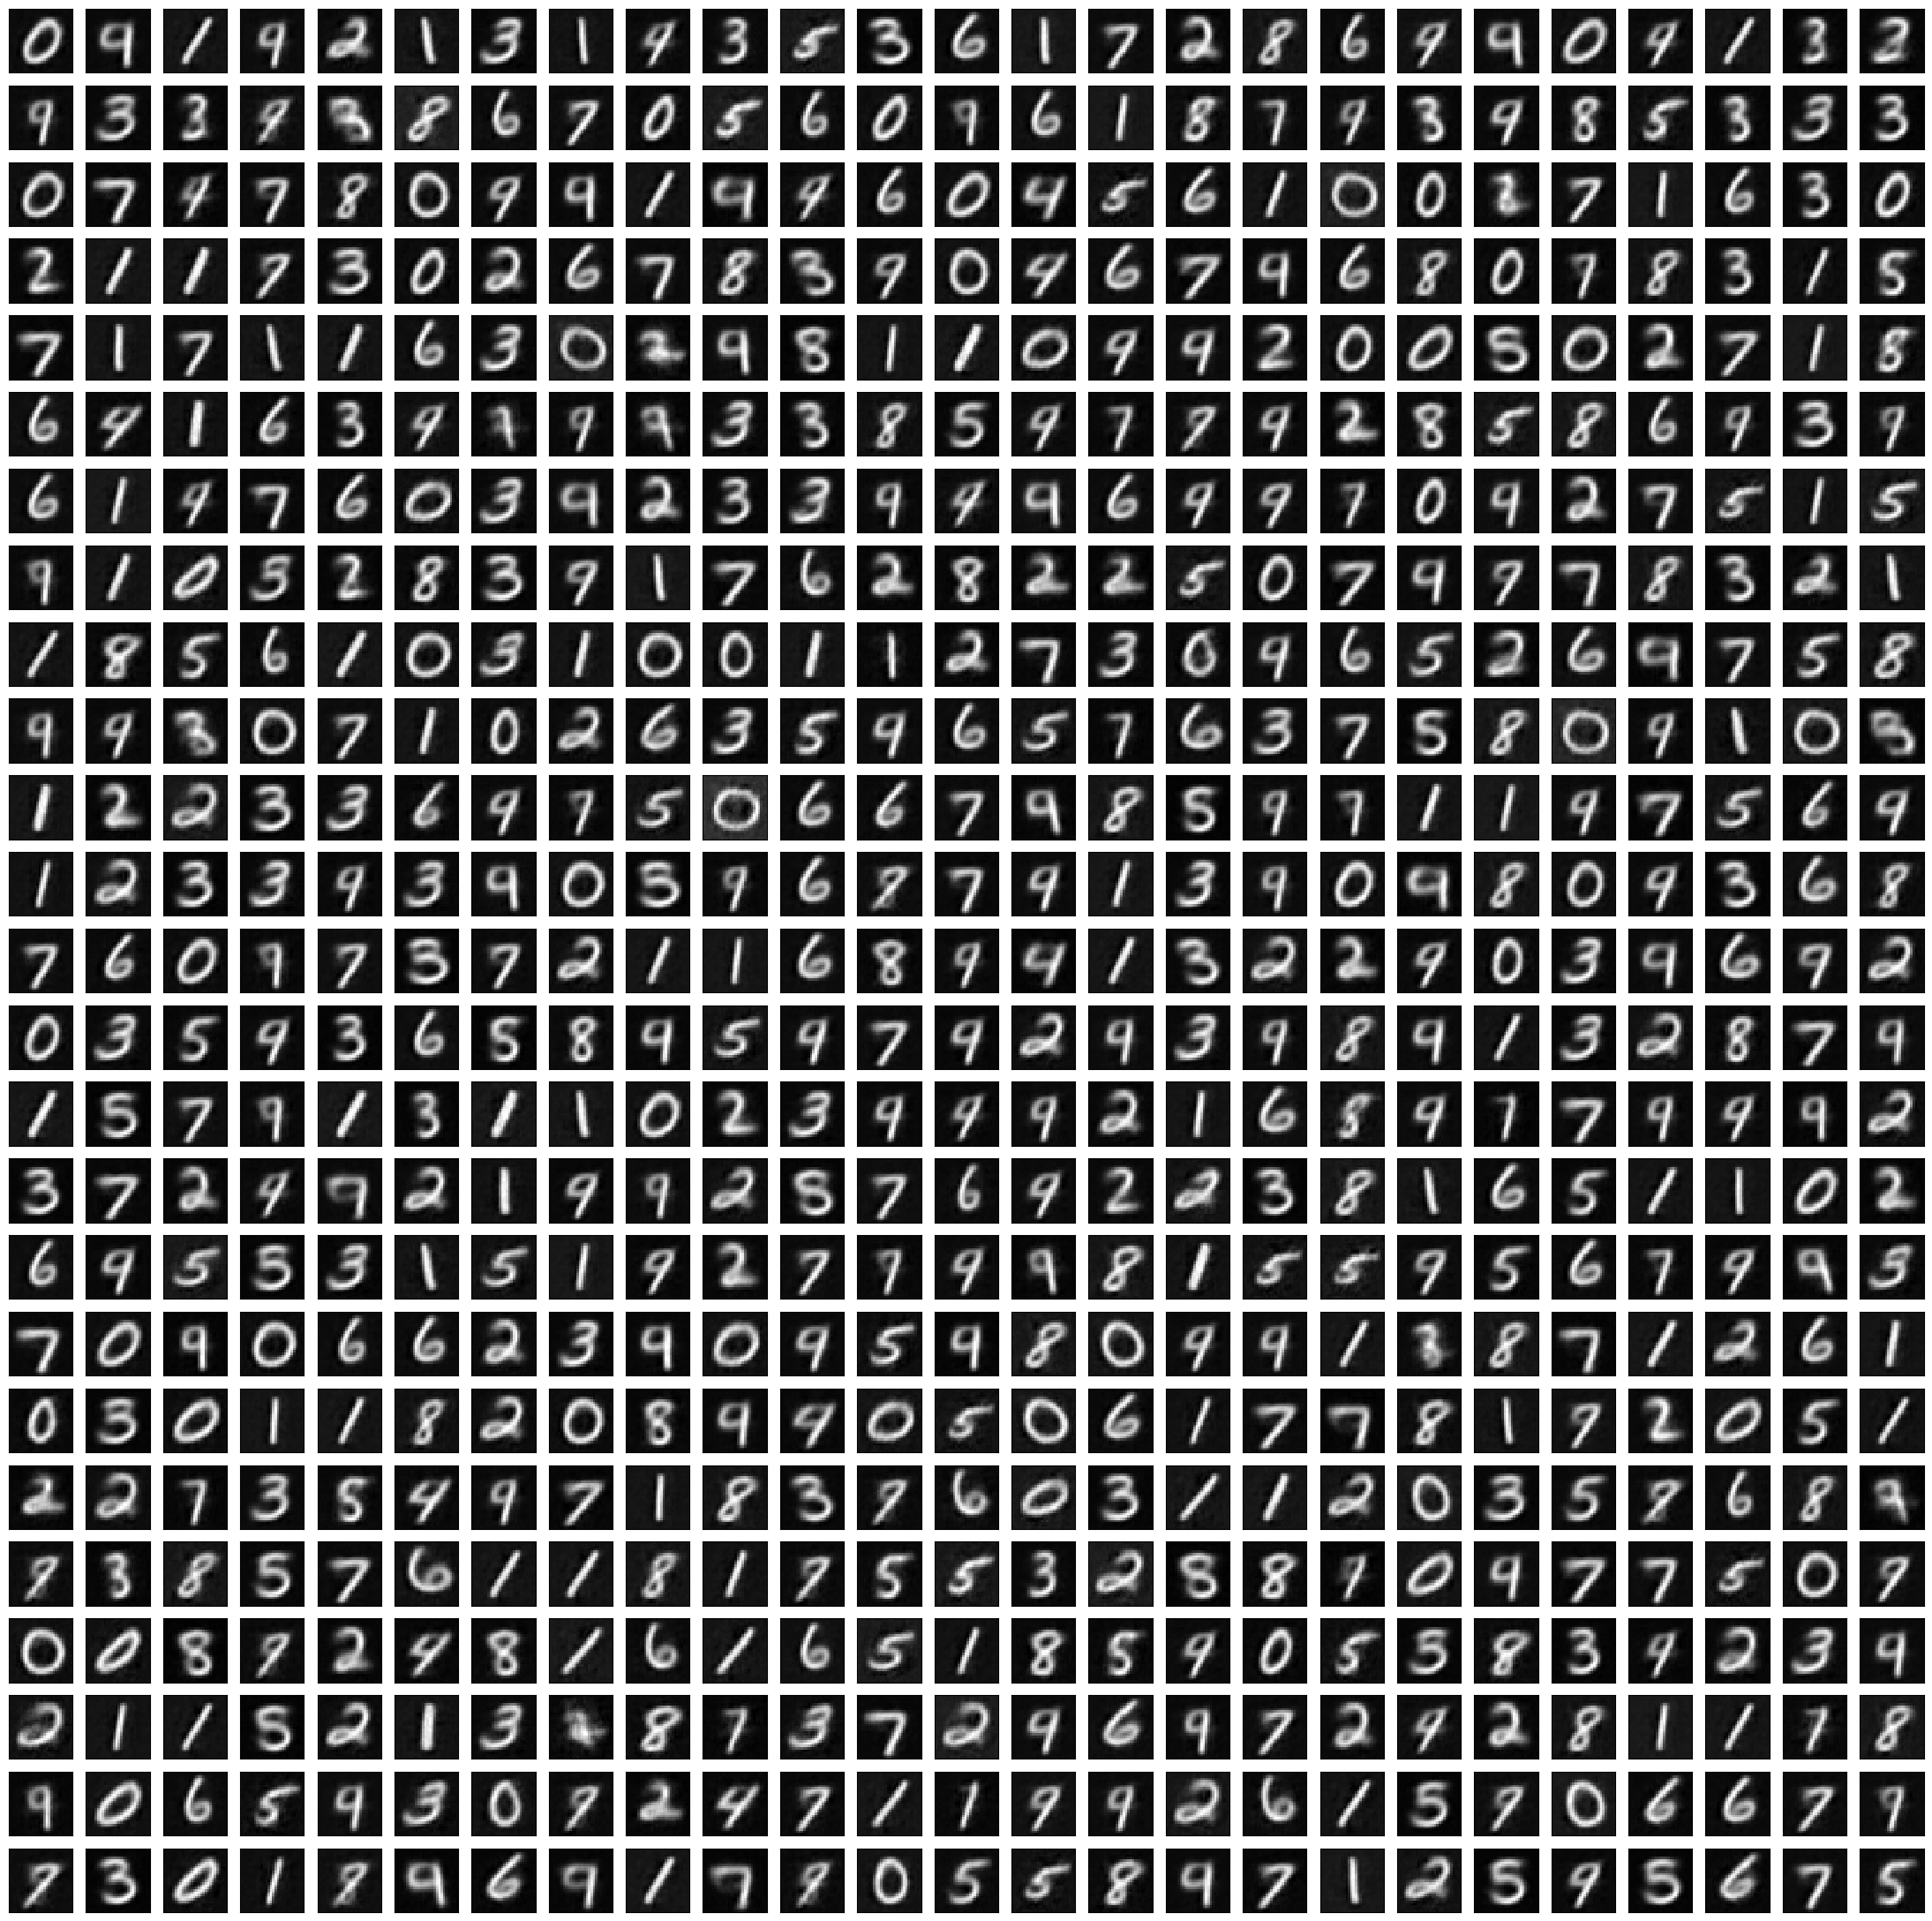

In [7]:
fig = plt.figure(figsize=(28,28))

decoded_images = autoencoder.predict(X[:26*26].reshape((-1, 28, 28, 1)), verbose=False)

ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25, 25, ind)
        plt.imshow(decoded_images[ind].reshape((28,28)), cmap = "gray", interpolation = "none")
        plt.xticks([])
        plt.yticks([])
        ind+=1

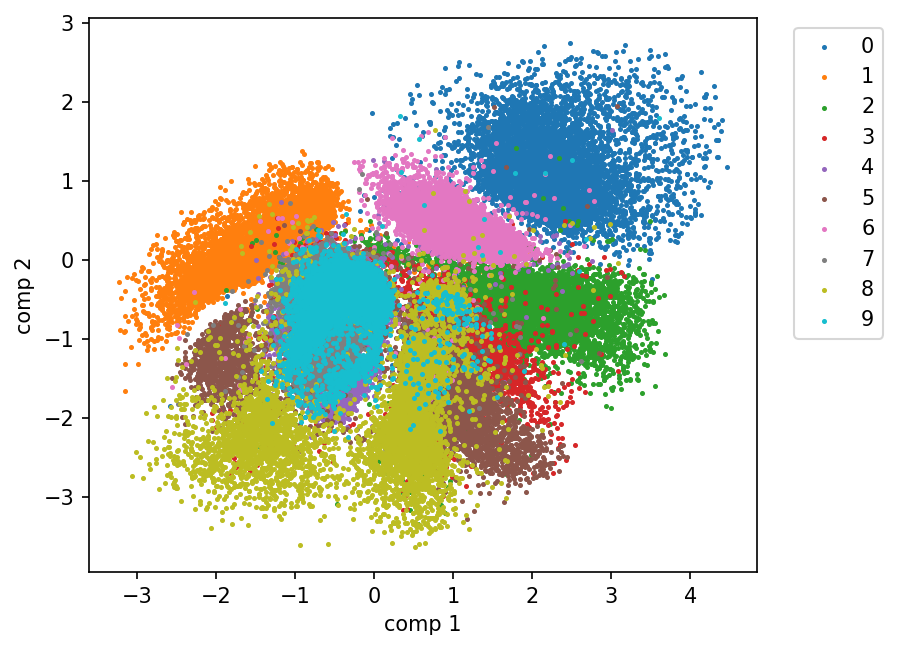

In [8]:
fig, ax = plt.subplots(dpi=150)

x_proj = encoder.predict(X.reshape((-1, 28, 28, 1)), verbose=0)

for i in range(10):
    ax.scatter(*x_proj[y_train == i].T, label=i, s=2)


ax.legend(bbox_to_anchor=(1.04, 1))
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_aspect('equal', 'box')

plt.show()

<font color="green">
Atividade (a) <br>
Compare a disposição dos códigos de dígitos das 10 classes com aquela da Parte 1. Procure justificar a diferença nos resultados.
</font>

**Resposta:**

In [9]:
def circle_path(radius, center, n_images, ax, *args, **kwargs):
    x0, y0 = center

    pts = np.zeros((n_images, 2))
    pts[:, 0] = radius * np.cos(2 * np.pi * np.linspace(1, n_images, num=n_images)/n_images) + x0
    pts[:, 1] = radius * np.sin(2 * np.pi * np.linspace(1, n_images, num=n_images)/n_images) + y0

    path = decoder.predict(pts, verbose=0).reshape((-1, 28, 28))

    for i in range(n_images):
        ax.add_artist(AnnotationBbox(OffsetImage(path[i], cmap='binary_r', zoom=0.4), pts[i], frameon=False))

In [10]:
def clear_artists(ax):
    for artist in ax.artists:
        artist.remove()

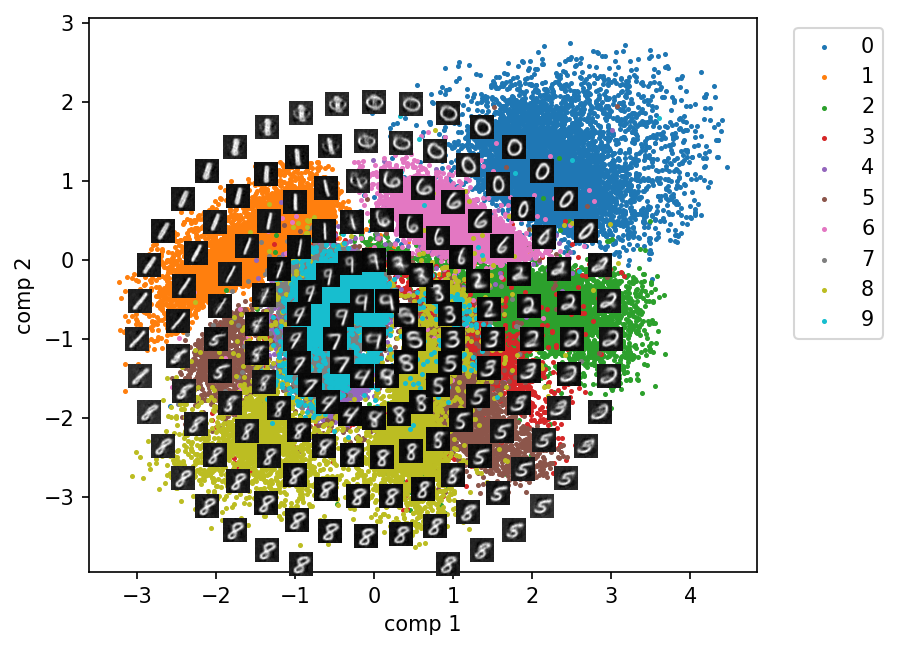

In [11]:
clear_artists(ax)

circle_path(radius=3, center=(0, -1), n_images=40, ax=ax)
circle_path(radius=2.5, center=(0, -1), n_images=35, ax=ax)
circle_path(radius=2, center=(0, -1), n_images=30, ax=ax)
circle_path(radius=1.5, center=(0, -1), n_images=25, ax=ax)
circle_path(radius=1, center=(0, -1), n_images=20, ax=ax)
circle_path(radius=0.5, center=(0, -1), n_images=10, ax=ax)
circle_path(radius=0, center=(0, -1), n_images=1, ax=ax)

fig

<font color="green">
Atividade (b) <br>
Se necessário, redefina os valores de [center], [radius] e [n_images] para que as amostras excursionem por toda a distribuição de códigos. Em outras palavras, não deixe nenhuma região colorida sem amostras.
</font>

### Pre-trained convolutional autoencoder

The idea here is to force the encoder to separate the data before the decoder tries to decode the latent space. To do this, we will pre-train the encoder as a classifier, in a supervised manner. After this encoder pre-training, we will pre-train the decoder to decode in this latent space learned by the classifier, freezing the encoder weights. The decoder will present low performance in this pre-training stage, given that the encoder is not flexible. Finally, to improve overall performance, we will fine-tune the entire autoencoder.

In [12]:
encoder = tf.keras.models.Sequential([
    Conv2D(8, (3, 3), activation='selu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='selu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(256, (3, 3), activation='selu', padding='same'),
    Flatten(),
    Dense(2),

], name='encoder')

# Define the decoder
decoder = tf.keras.models.Sequential([
    Dense(256, activation='relu', input_shape=(2,)),
    Reshape((1, 1, 256)),
    Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='selu'),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='selu'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='selu'),
    Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='selu'),
    Conv2D(8, (3, 3), padding='same', activation='selu'),
    Conv2D(1, (3, 3), padding='same', activation=None),
], name='decoder')

In [13]:
pre_train_encoder = Sequential([encoder, Dense(10, 'softmax')])

pre_train_encoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

history = pre_train_encoder.fit(X.reshape((-1, 28, 28, 1)), y_train, batch_size = 128, epochs = 20, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [14]:
pre_train_decoder = Sequential([decoder])

x_proj = encoder.predict(X.reshape((-1, 28, 28, 1)), verbose=0)

pre_train_decoder.compile(optimizer='adam', loss='mse')

history = pre_train_decoder.fit(x_proj, X.reshape((-1, 28, 28, 1)), batch_size = 128, epochs = 20, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [15]:
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer = Adam(learning_rate=1e-10), loss='mse')

history = autoencoder.fit(X.reshape((-1, 28, 28, 1)), X.reshape((-1, 28, 28, 1)), batch_size = 128, epochs = 50, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

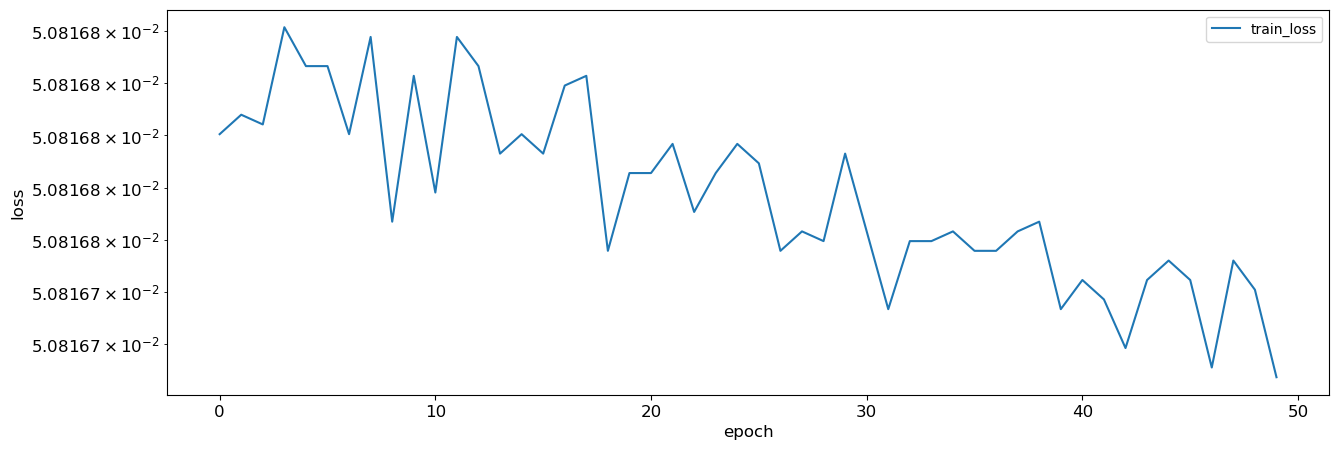

In [16]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

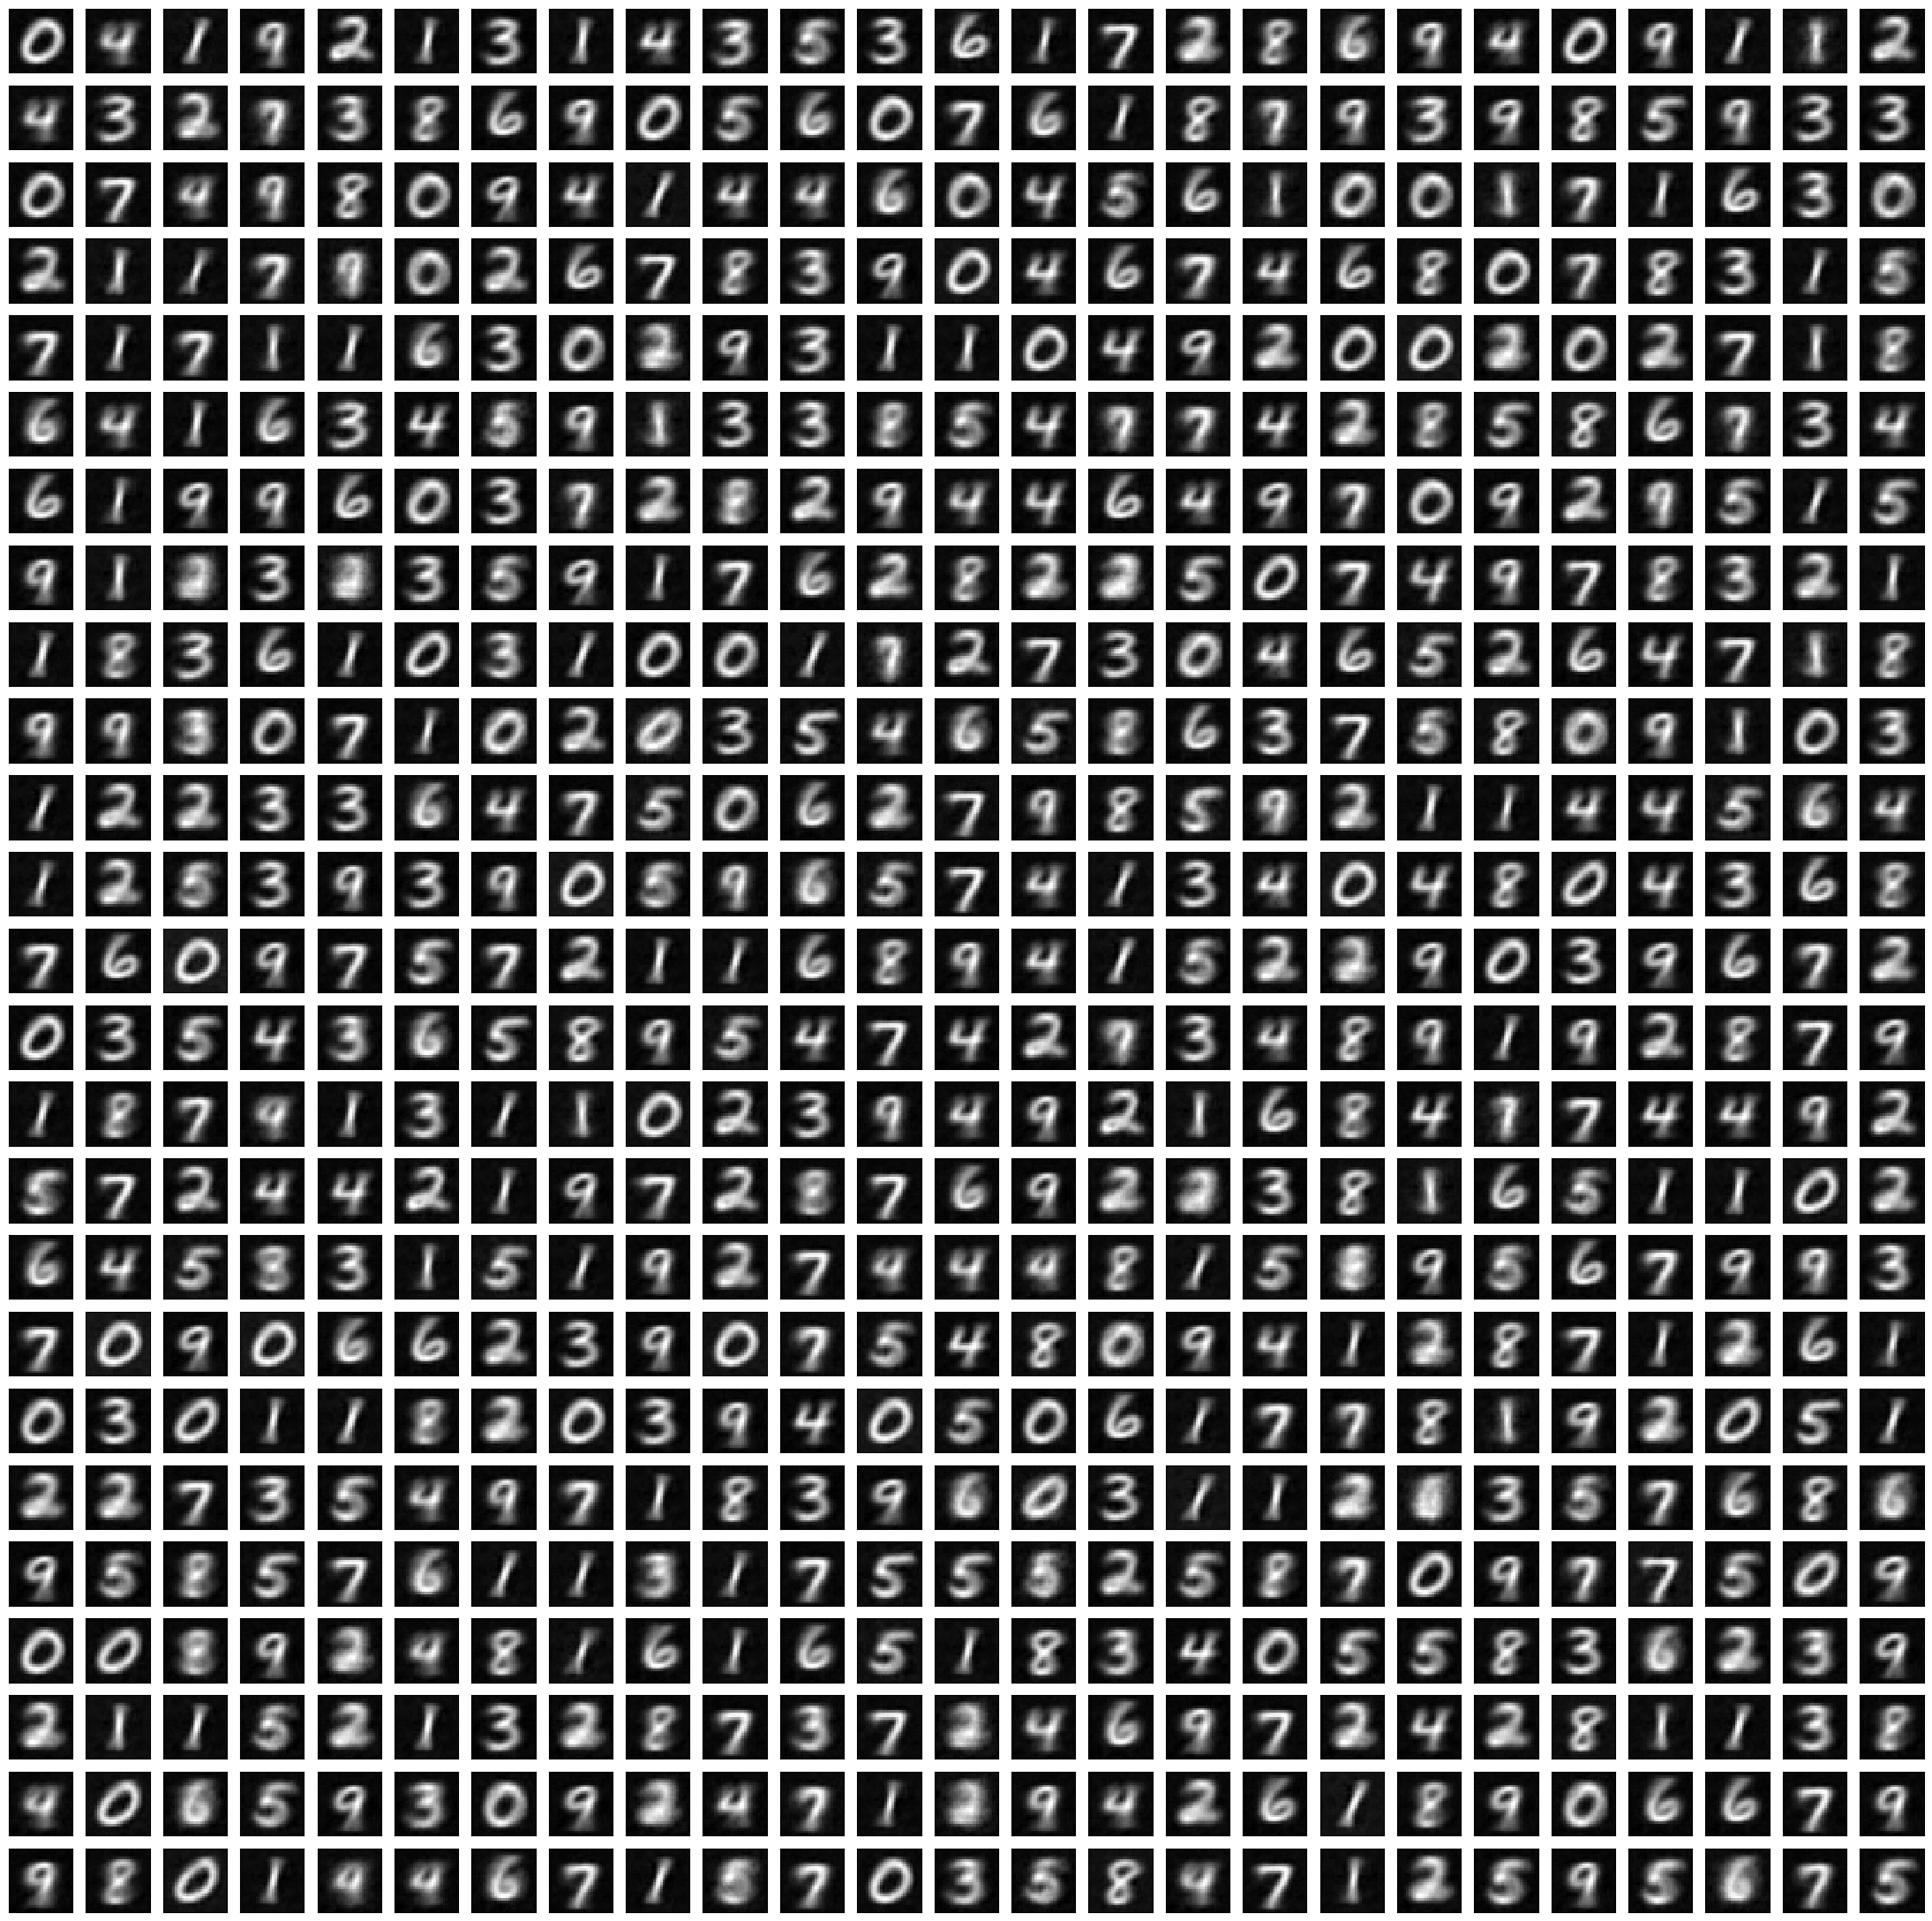

In [17]:
fig = plt.figure(figsize=(28,28))

decoded_images = decoder.predict(x_proj, verbose=False)

ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25, 25, ind)
        plt.imshow(decoded_images[ind].reshape((28,28)), cmap = "gray", interpolation = "none")
        plt.xticks([])
        plt.yticks([])
        ind+=1

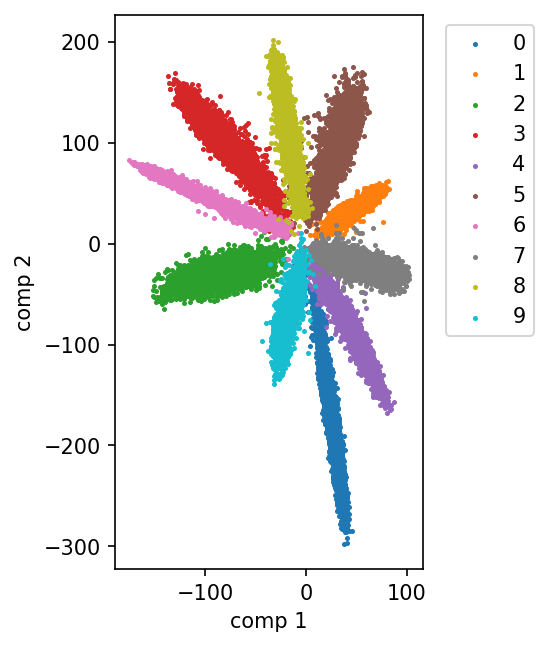

In [18]:
fig, ax = plt.subplots(dpi=150)

for i in range(10):
    ax.scatter(*x_proj[y_train == i].T, label=i, s=2)


ax.legend(bbox_to_anchor=(1.04, 1))
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_aspect('equal', 'box')

plt.show()

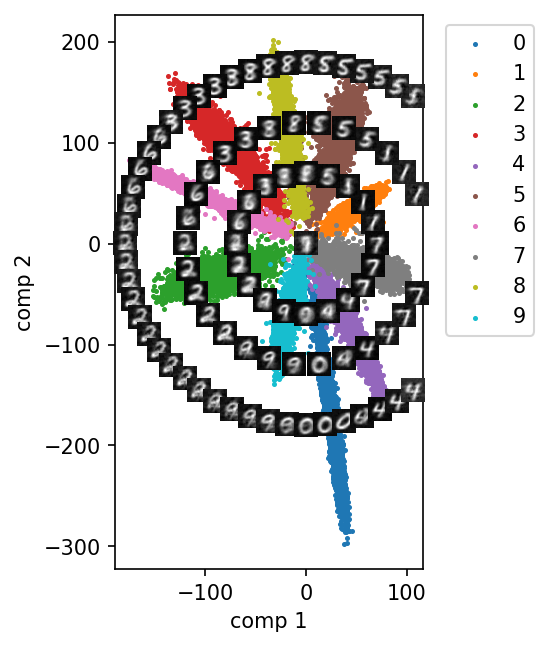

In [19]:
clear_artists(ax)

circle_path(radius=180, center=(0, 0), n_images=60, ax=ax)
circle_path(radius=120, center=(0, 0), n_images=30, ax=ax)
circle_path(radius=70, center=(0, 0), n_images=20, ax=ax)
circle_path(radius=0, center=(0, 0), n_images=1, ax=ax)

fig

<font color="green">
Atividade (c) <br>
Se necessário, redefina os valores de [center], [radius] e [n_images] para que as amostras excursionem por toda a distribuição de códigos. Em outras palavras, não deixe nenhuma região colorida sem amostras.
</font>

<font color="green">
Atividade (d) <br>
Qual foi a estratégia adotada para que o código do autoencoder fizesse o desemaranhamento (disentanglement) das classes? É sempre possível adotar esta estratégia ao se treinar um autoencoder?
</font>

**Resposta:**